In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd import mtt_phd
from utils import *

In [6]:
# Measurement parameters
dim = 2
dt = 1.0

birth_prob = 0.05
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-2, 2)

area = (-100, 100)

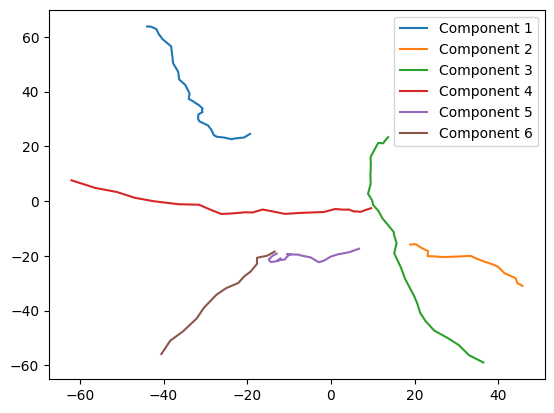

In [7]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.25

truths = simulate_motion(F, Q, num_steps=30, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
plt.legend()

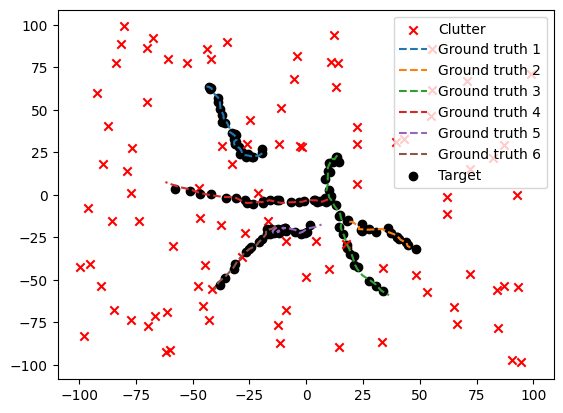

In [8]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=30, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter')
        else:
            plt.scatter(measurement[0], measurement[1], color='black', marker='o', label=f'Target')
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [11]:
# assume 3 components
num_components = 3

# assume each component has the same weight
component_weight = 0.5

# the variance of pos and vel
pos_var = 50
vel_var = 2

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = []
for _ in range(num_components):
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(*vel_bounds, 2),
    ]))
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var]) for _ in range(num_components)])

In [13]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[0.5, 0.5, 0.5]
Initial means:
[[ 17.27884752  10.03824979   1.25403953  -0.07438855]
 [ 49.38783214  44.63072858   1.45069796  -1.18742153]
 [-14.55228529  -7.86502379  -1.6362346   -0.4857671 ]]
Initial covariances:
[[[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]

 [[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]

 [[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]]


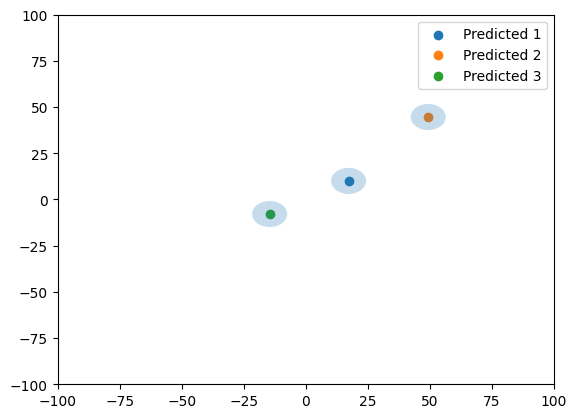

In [17]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
plt.legend()

In [14]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=0.9,
    clutter_intensity=3.0,
    merging_threshold = 3.0,
    truncation_threshold = 0.001, # make sure squared
    threshold_weight= 0.1
)

In [15]:
history = filter.full_PHD_filter_run()

In [16]:
history

[[array([17.40276609, 10.03089904,  1.25403953, -0.07438855]),
  array([49.53118361, 44.5133929 ,  1.45069796, -1.18742153]),
  array([-14.71397066,  -7.91302512,  -1.6362346 ,  -0.4857671 ]),
  array([17.44660091, 10.0282988 ,  1.25403953, -0.07438855]),
  array([49.58189261, 44.4718867 ,  1.45069796, -1.18742153]),
  array([-14.77116508,  -7.93000506,  -1.6362346 ,  -0.4857671 ]),
  array([17.4917307 , 10.02562174,  1.25403953, -0.07438855]),
  array([49.63409965, 44.42915433,  1.45069796, -1.18742153]),
  array([-14.83004913,  -7.94748662,  -1.6362346 ,  -0.4857671 ]),
  array([17.53817219, 10.02286687,  1.25403953, -0.07438855]),
  array([17.53817219, 10.02286687,  1.25403953, -0.07438855]),
  array([49.6878241 , 44.38517994,  1.45069796, -1.18742153]),
  array([49.6878241 , 44.38517994,  1.45069796, -1.18742153]),
  array([-14.89064465,  -7.96547628,  -1.6362346 ,  -0.4857671 ]),
  array([-14.89064465,  -7.96547628,  -1.6362346 ,  -0.4857671 ]),
  array([17.58594093, 10.02003327, 

In [23]:
for truth in truths.values():
    print(truth[0])

[-19.32903481  24.51802353  -1.48819165  -1.56423036]
[ 18.95934512 -15.87268024   0.91034553  -0.74775831]
[13.69493445 23.35527159 -0.33742471 -1.35721099]
None
None
None
